## XGBoost模型预测

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import os
path = r"F:\Diverse\statistics\Python_data_analysis\Kaggle项目\20171024-Grocery_sale"
os.chdir(path)

%matplotlib inline

### 导入数据

#### 基础数据

In [3]:
#load transactions info
dtypes = {"transactions": "int16", "store_nbr": "int8"}
transactions = pd.read_csv(r"dataset/transactions.csv", parse_dates=["date"], dtype=dtypes)

#load stores info
dtypes = {"store_nbr": "int8", "cluster": "int32"}
stores = pd.read_csv(r"dataset/stores.csv",dtype=dtypes)

#load items info
dtypes = {"item_nbr": "int32", "class": "int16", "perishable": "int8"}
items = pd.read_csv(r"dataset/items.csv", dtype=dtypes)

#load oil info
dtypes = {"dcoilwtico": "float32"}
oil = pd.read_csv(r"dataset/oil.csv",index_col="date", parse_dates=["date"], dtype=dtypes)
oil.fillna(oil.mean(), inplace=True)

#load holiday events info
holiday = pd.read_csv(r"dataset/holidays_events.csv", parse_dates=["date"])

### 特征工程

#### 商店聚类
- hierarchical clustering,树状图确定分类数目
- agglomerative进行聚类操作

In [4]:
from scipy.cluster.hierarchy import ward, dendrogram
from sklearn.cluster import AgglomerativeClustering

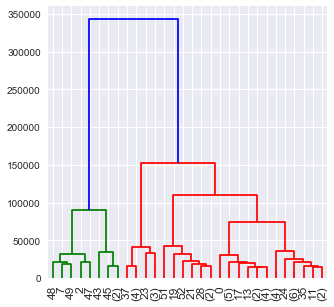

In [5]:
hc = transactions.groupby(["store_nbr","date"]).transactions.mean().unstack(level=1).fillna(0)
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
w = ward(hc)
dendrogram(w,truncate_mode='lastp',ax=ax,leaf_font_size=12,leaf_rotation=90,show_contracted=True)
plt.show()

In [6]:
# divide into 6 cluster
clustering = AgglomerativeClustering(n_clusters=6)
cluster = clustering.fit_predict(hc)

#### items信息处理

In [7]:
# items -> class
bins = range(1000,9000,1000)
labels = range(7)
bin_class = pd.cut(items["class"], bins=bins, labels=labels)
items["bin_class"] = bin_class

# items -> family
family = items.family.unique()
num_family = np.count_nonzero(family)

# store -> state
state = stores.state.unique()
num_state = np.count_nonzero(state)

#### 数据映射

In [8]:
# maping form store_nbr to cluster_nbr
maps_store = dict(zip(hc.index.values,cluster))
stores["cluster_store"] = stores.store_nbr.map(maps_store)
print(transactions.columns)

# maping store_type
maps_store_type = dict(zip(np.sort(stores.type.unique()),range(5)))
stores["type"] = stores.type.map(maps_store_type)
print(stores.columns)

# mapping store state
maps_state = dict(zip(state,range(num_state)))
stores.state = stores.state.map(maps_state)
print(stores.columns)

# mapping items family
maps_family = dict(zip(family,range(num_family)))
items["family"] = items.family.map(maps_family)
print(items.columns)

Index(['date', 'store_nbr', 'transactions'], dtype='object')
Index(['store_nbr', 'city', 'state', 'type', 'cluster', 'cluster_store'], dtype='object')
Index(['store_nbr', 'city', 'state', 'type', 'cluster', 'cluster_store'], dtype='object')
Index(['item_nbr', 'family', 'class', 'perishable', 'bin_class'], dtype='object')


#### 数据合并

In [9]:
def data_merge(train, number=0, istrain=True, iflog=False):
    train = train.reset_index()
    
    if istrain:
        train = train.sort_values(by=["store_nbr","item_nbr","date"])
        mean = train.unit_sales.ewm(span=7).mean()
        train.unit_sales = mean

    train["year"] = train["date"].dt.year
    train["month"] = train["date"].dt.month
    train["day"] = train["date"].dt.day
    train["dayofweek"] = train["date"].dt.dayofweek
    train["weekofyear"] = train["date"].dt.dayofweek

    train = pd.merge(train, stores[["store_nbr","type","cluster_store","state"]], on="store_nbr")
    train = pd.merge(train, items[["item_nbr","perishable","bin_class","family"]], on="item_nbr")
    train = pd.merge(train, oil, how="left", left_on="date", right_index=True)
    maping = {None:0, False:0, True:1}
    train.onpromotion = train.onpromotion.map(maping)
    
    train = train.set_index("id")
    train.drop(["date","store_nbr"],axis=1,inplace=True)
    category_list = list(set(train.columns) - set(["unit_sales","dcoilwtico","year","month","day","dayofweek","weekofyear","item_nbr"]))
    train = pd.get_dummies(train, columns=category_list)
    print("the train set shape is ", train.shape)
    
    if istrain:
        if iflog:
            train = train[train.unit_sales > 0]
            unit_sales = np.log(train.unit_sales.values)
        else:
            unit_sales = train.unit_sales.values
        train.drop(labels=["unit_sales"], axis=1, inplace=True)
        
        dtrain = xgb.DMatrix(data=train,label=unit_sales)
        # filename = ("data_xgboost/dtrain-%.5d.buffer" % (number)) 
        filename = "data_xgboost/dtrain.buffer"
        dtrain.save_binary(filename)
        print("the filename of data buffer is", filename)
    else:
        dtrain = xgb.DMatrix(data=train)
        filename = ("data_xgboost/dtest-%.3d.buffer" % (number)) 
        dtrain.save_binary(filename)
        print("the filename of data buffer is", filename)
    del train
        
    return dtrain

### XGBoost模型
- xgb.DMatrix 将数据转化为XGBoost使用的二进制数据
- xgb.train 训练XGBoost模型

In [10]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

D:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


#### partial_fit 流式增量训练

##### 基础训练器

In [10]:
def model_fit(dtrain, number, filename=None):
    parameters = {"eta":0.001, 
                  "max_depth":5,
                  "min_child_weight":1, 
                  "subsample":0.8,
                 "colsample_bytree":0.8,
                  "objective":"reg:linear", 
                  "silent":1}

    num_round = 200
    #watchlist=[(dtrain,"eval"),(dev,"val")]
    watchlist=[(dtrain,"eval")]
    
    model = xgb.train(parameters, 
                      dtrain,
                      num_round, 
                      evals = watchlist,
                      early_stopping_rounds = 50,
                      verbose_eval = 100,
                      xgb_model=filename
                     )

    filename = ("model_xgboost/xgbmodel-%0.3d.model" % (number))
    model.save_model(filename)
    
    return filename

##### pandas 分批导入数据

In [11]:
#load train set
dtypes = {"store_nbr": "int64",
         "item_nbr": "int64",
         "unit_sales": "float64",
         "onpromotion": bool}
reader = pd.read_csv(r"dataset/train.csv", index_col="id", parse_dates=["date"],
                     dtype=dtypes, iterator=True, chunksize=250000)

##### 增量训练器

In [12]:
def partial_fit(reader,thread=245):
    for i,read in enumerate(reader):
        if i >= thread:
            print("iterator: ",i)
            dtrain = data_merge(read, number=i)
            if i == thread:
                model_file = model_fit(dtrain, i)
            else:
                model_file = model_fit(dtrain, i, filename=model_file)
            print(model_file)
    return model_file

#### 加载最终模型

In [ ]:
model_file = partial_fit(reader,thread=400)

iterator:  400
the train set shape is  (250000, 79)
the filename of data buffer is data_xgboost/dtrain.buffer
[0]	eval-rmse:14.8257
Will train until eval-rmse hasn't improved in 50 rounds.
[100]	eval-rmse:14.3399
model_xgboost/xgbmodel-400.model
iterator:  401
the train set shape is  (250000, 79)
the filename of data buffer is data_xgboost/dtrain.buffer
[0]	eval-rmse:19.0172
Will train until eval-rmse hasn't improved in 50 rounds.
[100]	eval-rmse:18.4667
model_xgboost/xgbmodel-401.model
iterator:  402
the train set shape is  (250000, 79)
the filename of data buffer is data_xgboost/dtrain.buffer
[0]	eval-rmse:18.99
Will train until eval-rmse hasn't improved in 50 rounds.
[100]	eval-rmse:18.5688
model_xgboost/xgbmodel-402.model
iterator:  403
the train set shape is  (250000, 79)
the filename of data buffer is data_xgboost/dtrain.buffer
[0]	eval-rmse:16.7938
Will train until eval-rmse hasn't improved in 50 rounds.
[100]	eval-rmse:16.4584
model_xgboost/xgbmodel-403.model
iterator:  404
the

In [11]:
model_file = r"model_xgboost/xgbmodel-458.model"
xgb_model = xgb.Booster()
xgb_model.load_model(model_file)

### 测试集预测

#### 转化测试集 & 预测

In [12]:
#test set
dtypes = {"store_nbr": "int16",
         "item_nbr": "int32",
         "onpromotion": bool}
testset = pd.read_csv(r"dataset/test.csv", index_col="id", parse_dates=["date"], 
                      iterator=True, chunksize=500000, dtype=dtypes)

results = pd.DataFrame(columns=["unit_sales"])
for i, test in enumerate(testset):
    testindex = test.index
    dtest = data_merge(test, number=i, istrain=False)
    ypred = xgb_model.predict(dtest)
    temp = pd.DataFrame(data=ypred,index=testindex,columns=["unit_sales"])
    results = pd.concat([results, temp])

the train set shape is  (500000, 78)
the filename of data buffer is data_xgboost/dtest-000.buffer
the train set shape is  (500000, 78)
the filename of data buffer is data_xgboost/dtest-001.buffer
the train set shape is  (500000, 78)
the filename of data buffer is data_xgboost/dtest-002.buffer
the train set shape is  (500000, 78)
the filename of data buffer is data_xgboost/dtest-003.buffer
the train set shape is  (500000, 78)
the filename of data buffer is data_xgboost/dtest-004.buffer
the train set shape is  (500000, 78)
the filename of data buffer is data_xgboost/dtest-005.buffer
the train set shape is  (370464, 78)
the filename of data buffer is data_xgboost/dtest-006.buffer


#### 直接预测

In [ ]:
#test set
dtypes = {"store_nbr": "int16",
         "item_nbr": "int32",
         "onpromotion": bool}
testset = pd.read_csv(r"dataset/test.csv", index_col="id", parse_dates=["date"], 
                      iterator=True, chunksize=500000, dtype=dtypes)

results = pd.DataFrame(columns=["unit_sales"])
for i, test in enumerate(testset):
    testindex = test.index
    filename = ("data_xgboost/dtest-%.3d.buffer" % (i)) 
    dtest = xgb.DMatrix(filename)
    ypred = xgb_model.predict(dtest)
    temp = pd.DataFrame(data=ypred,index=testindex,columns=["unit_sales"])
    results = pd.concat([results, temp]) 

In [13]:
results.index.name = "id"
results.to_csv(r"results\results_xgboost_20171222.csv",float_format="%.3f")

In [14]:
results.describe()

,unit_sales
count,3.370464e+06
mean,8.888513e+00
std,5.022474e+00
min,3.335421e+00
25%,5.744958e+00
50%,7.374337e+00
75%,1.007940e+01
max,7.334799e+01
